In [1]:
#!/usr/bin/env python

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import pandas as pd
import wradlib
from scipy import stats
import matplotlib.cm as cm
my_cmap = cm.get_cmap('jet',40)
my_cmap.set_under('lightgrey')
my_cmap.set_over('darkred')
from pcc import get_miub_cmap as my_cmap
from pcc import plot_radar
from pcc import boxpol_pos
from pcc import plot_borders
import wradlib as wrl
from osgeo import osr
from satlib import ipoli_radi
from satlib import corcor
Pos = boxpol_pos()
blon0, blat0 = Pos['lon_ppi'], Pos['lat_ppi']
bbx, bby = Pos['gkx_ppi'], Pos['gky_ppi']
from time import *

% matplotlib inline

print ("_")

_


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

In [132]:
# Pfad mit String
# ---------------

# Hohe von DPR
TH = 15 #Threshold um Nullen fuer Niederschlag raus zu filtern


ZP = '20141007023744' ; pfadnr=0; enigma='alt'# 0.47



#-----------------------------#

year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]


#pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dpr/2A.GPM.DPR.V6-20160118.' + year + m + d + '*.HDF5')
pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.' + year + m + d + '*.HDF5')

print ('GPM:',pfad_radar)
pfad_radar = pfad_radar[pfadnr]

gpmku = h5py.File(pfad_radar, 'r')
gpmku_HS = gpmku['NS']['SLV']
dpr_lat = np.array(gpmku['NS']['Latitude'])
dpr_lon = np.array(gpmku['NS']['Longitude'])
dpr_alt = np.array(gpmku['NS']['VER']['heightZeroDeg'])
dpr_alt[dpr_alt == -9999.9] = np.nan

#heightZeroDeg
'''(4-byte float, array size: nrayMS x nscan):
Height of freezing level (0 degrees C level) Values are in m. Sp
ecial values are defined as:
-9999.9  Missing value'''
dpr_zero_deg = np.array(gpmku['NS']['VER']['heightZeroDeg'])
dpr_zero_deg[dpr_zero_deg == -9999.9] = np.nan

##### Bin Number of real surface equal to binNode[4]
"""Range bin number for real surface.  For NS and MS swaths, bin number
s are 1-based
ranging from 1 at the top of the data window with 176 at the Elli
psoid. For HS swaths,
bin numbers are 1-based ranging from 1 at the top of the data win
dow with 88 at the
Ellipsoid. Special values are defined as:
-9999  Missing value"""
bin_surf = np.array(gpmku['NS']['PRE']['binRealSurface'])


####binDEML2
'''(2-byte integer, array size: nray x nscan):
Range bin number of the digital elevation model surface estima
te. For information on
this experimental field contact the Joint DPR Team. Special va
lues are defined as:
-9999  Missing value'''
bin_DEM = np.array(gpmku['NS']['Experimental']['binDEML2'],dtype=float)
bin_DEM[bin_DEM == -9999] = np.nan

#elevation
"""(4-byte float, array size: nray x nscan):
Elevation of the measurement point. It is a copy of DEMHmean of l
evel 1B product.
Values are in m. Special values are defined as:
-9999.9  Missing value"""
bin_ele = np.array(gpmku['NS']['PRE']['elevation'],dtype=float)
bin_ele[bin_ele == -9999] = np.nan

######
Z_dpr = np.array(gpmku_HS['zFactorCorrectedNearSurface'])
Z_dpr[Z_dpr < TH] = np.nan
Z3d_dpr = np.array(gpmku_HS['zFactorCorrected'])

('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007-S015721-E032951.003445.V05A.HDF5'])


In [91]:
proj_stereo = wrl.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

#dpr_lon, dpr_lat = wradlib.georef.reproject(dpr_lon, dpr_lat,
#                                            projection_target=proj_stereo ,
#                                            projection_source=proj_wgs)

0

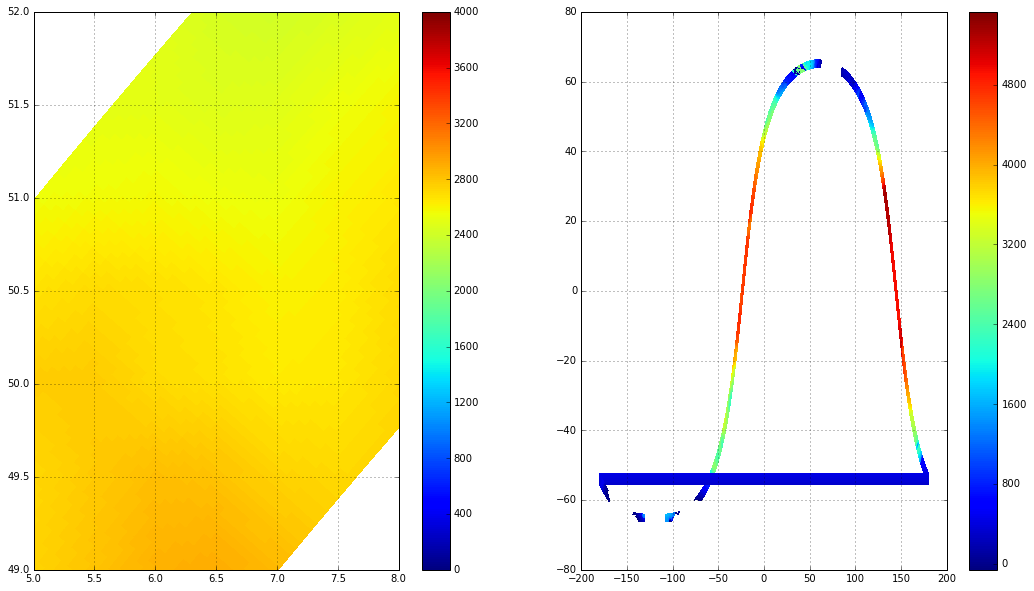

In [104]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.pcolormesh(dpr_lon, dpr_lat, np.ma.masked_invalid(dpr_alt), vmin=0, vmax=4000)
plt.colorbar()
plt.grid()
plt.xlim(5,8)
plt.ylim(49, 52)
plt.subplot(1,2,2)
plt.pcolormesh(dpr_lon, dpr_lat, np.ma.masked_invalid(dpr_alt))
plt.colorbar()
plt.grid()

In [93]:
np.nanmin(dpr_alt),np.nanmax(dpr_alt)

(-59.8099, 5531.718)

In [94]:
bin_surf.shape, Z3d_dpr.shape

((7930, 49), (7930, 49, 176))

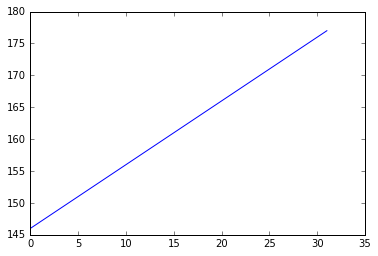

In [134]:
plt.plot(np.unique(bin_DEM))

(49, 52)

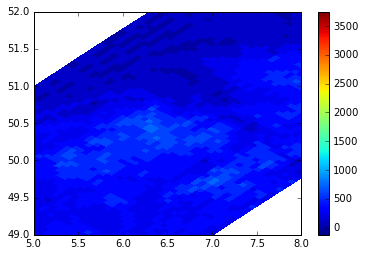

In [139]:
plt.pcolormesh(dpr_lon, dpr_lat, np.ma.masked_invalid((176-bin_DEM)*125))
plt.colorbar()
plt.xlim(5,8)
plt.ylim(49, 52)

In [96]:
Z_near = np.empty_like(bin_surf)
print Z_near.shape

(7930, 49)


In [97]:
for i in range(7930):
    for j in range(49):
        Z_near[i,j] = Z3d_dpr[i,j,bin_surf[i,j]-1]

In [98]:
Z_near[Z_near>-9999]

array([19, 18, 18, ..., 17, 17, 18], dtype=int16)

(49, 52)

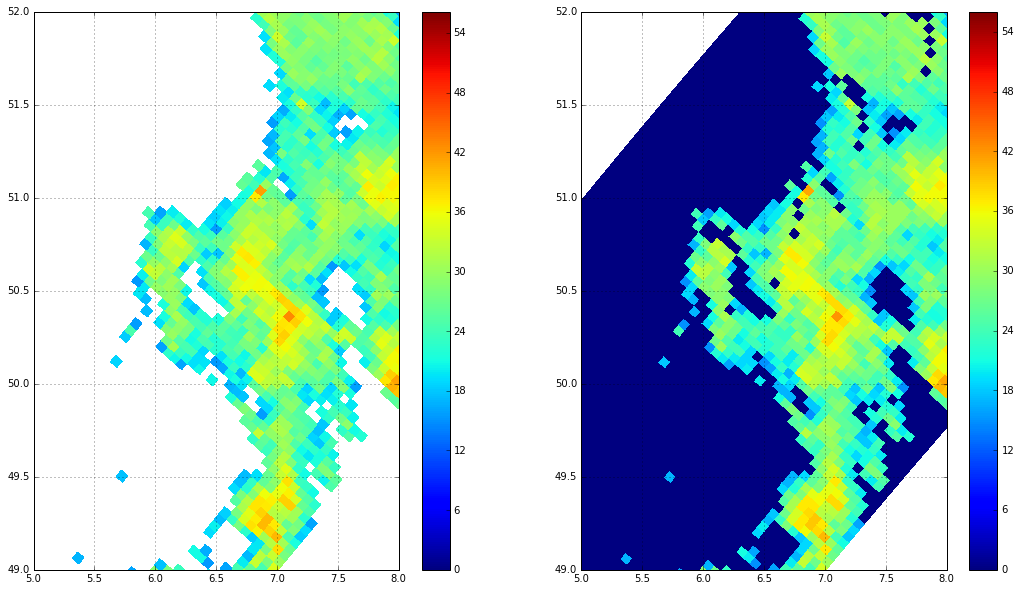

In [111]:
plt.figure(figsize=(18,10))
plt.subplot(1,2,1)
plt.pcolormesh(dpr_lon, dpr_lat, np.ma.masked_invalid(Z_dpr), vmin=0)
plt.colorbar()
plt.grid()
plt.xlim(5,8)
plt.ylim(49, 52)

plt.subplot(1,2,2)
plt.pcolormesh(dpr_lon, dpr_lat, np.ma.masked_invalid(Z_near), vmin=0)
plt.colorbar()
plt.grid()
plt.xlim(5,8)
plt.ylim(49, 52)

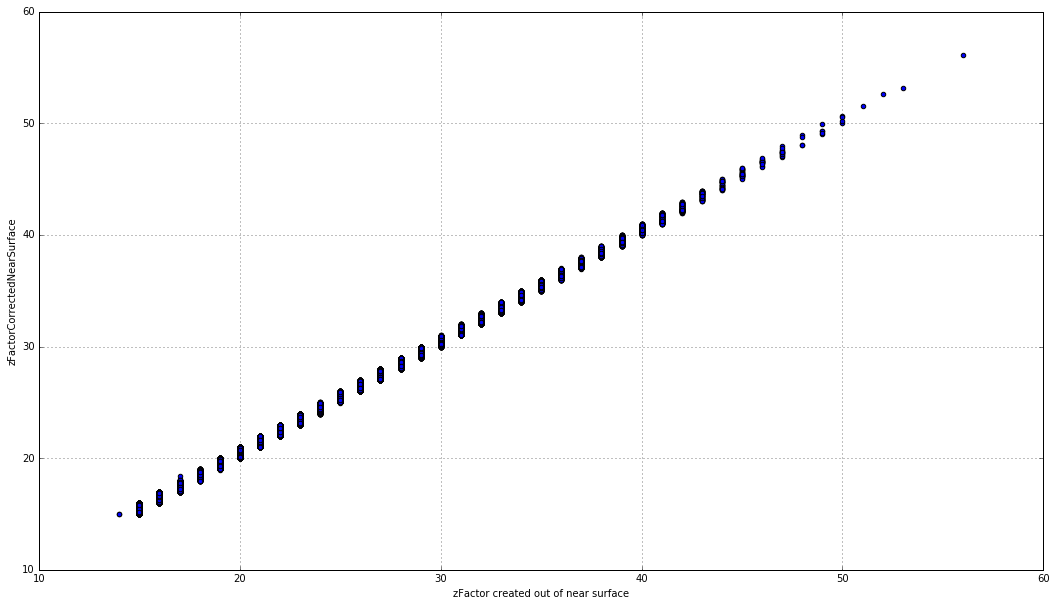

In [122]:
plt.figure(figsize=(18,10))

plt.scatter(Z_near,Z_dpr)
plt.xlim(10,60)
plt.ylim(10,60)
plt.ylabel('zFactorCorrectedNearSurface')
plt.xlabel('zFactor created out of near surface')
plt.grid()

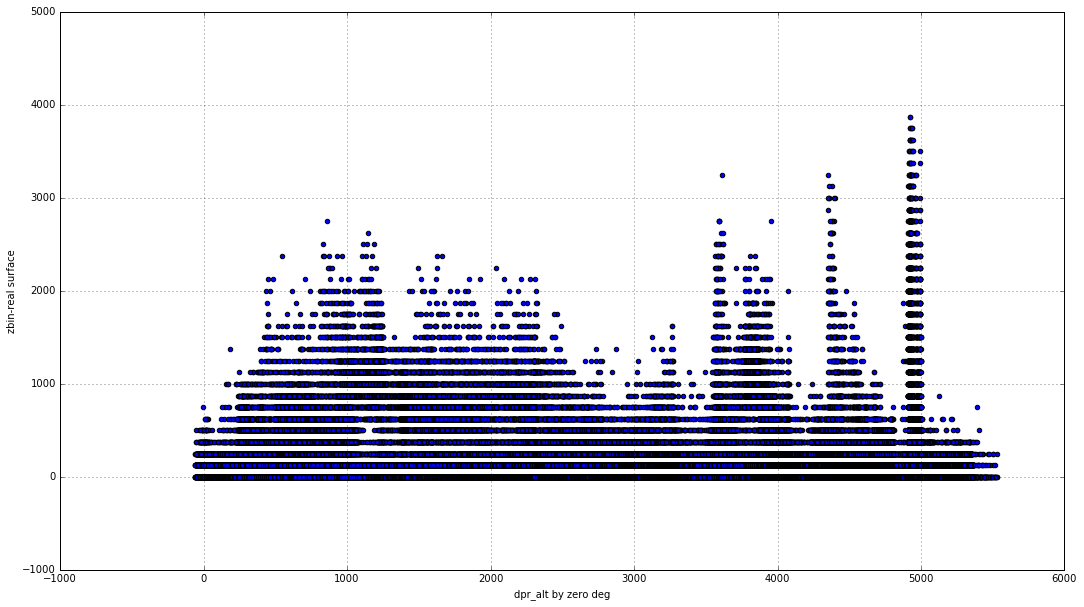

In [128]:
plt.figure(figsize=(18,10))

plt.scatter(dpr_alt,(176. - bin_surf)*125)
#plt.xlim(10,60)
#plt.ylim(10,60)
plt.ylabel('zbin-real surface')
plt.xlabel('dpr_alt by zero deg')
plt.grid()

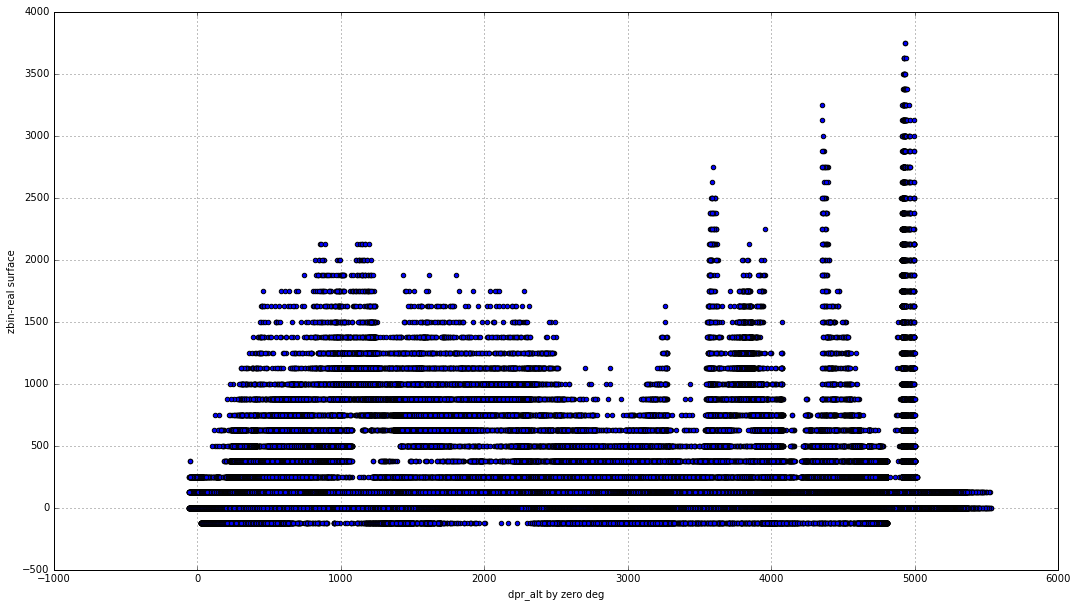

In [137]:
plt.figure(figsize=(18,10))

plt.scatter(dpr_alt,(176. - bin_DEM)*125)
#plt.xlim(10,60)
#plt.ylim(10,60)
plt.ylabel('zbin-real surface')
plt.xlabel('dpr_alt by zero deg')
plt.grid()

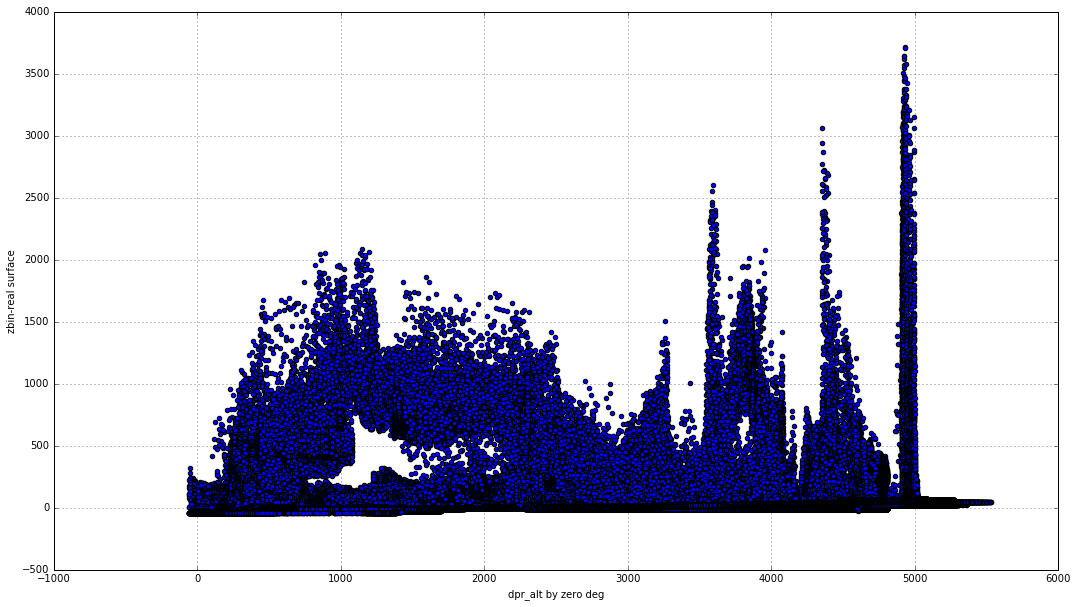

In [136]:
plt.figure(figsize=(18,10))

plt.scatter(dpr_alt,bin_ele)
#plt.xlim(10,60)
#plt.ylim(10,60)
plt.ylabel('zbin-real surface')
plt.xlabel('dpr_alt by zero deg')
plt.grid()